# BERT

## Installs and Imports

In [1]:
pip install transformers[torch]


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install transformers datasets evaluate


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install wikitextparser


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pickle
import re
import wikitextparser as wtp
from typing import Iterator, Optional, Union
from enum import Enum
from nltk.tokenize import sent_tokenize
import bz2
from datasets import Dataset
import re
import tqdm
import numpy as np
import requests
import evaluate
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
import nltk
nltk.download('punkt')

2024-01-02 13:43:21.209720: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-02 13:43:21.975660: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 13:43:21.975701: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 13:43:21.975730: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 13:43:22.312936: I tensorflow/core/platform/cpu_feature_g

True

In [5]:
class Namespace(Enum):
    OWL = 'http://www.w3.org/2002/07/owl#'
    WIKIPEDIA = 'http://en.wikipedia.org/wiki/'

    PREFIX_TEMPLATE = 'Template:'
    PREFIX_CATEGORY = 'Category:'
    PREFIX_FILE = 'File:'
    PREFIX_IMAGE = 'Image:'
    PREFIX_LIST = 'List_of_'
    PREFIX_LISTS = 'Lists_of_'
    PREFIX_LISTCATEGORY = PREFIX_CATEGORY + PREFIX_LISTS

    DBP_ONTOLOGY = 'http://dbpedia.org/ontology/'
    DBP_RESOURCE = 'http://dbpedia.org/resource/'
    DBP_TEMPLATE = DBP_RESOURCE + PREFIX_TEMPLATE
    DBP_CATEGORY = DBP_RESOURCE + PREFIX_CATEGORY
    DBP_FILE = DBP_RESOURCE + PREFIX_FILE
    DBP_IMAGE = DBP_RESOURCE + PREFIX_IMAGE
    DBP_LIST = DBP_RESOURCE + PREFIX_LIST

    CLG_ONTOLOGY = 'http://caligraph.org/ontology/'
    CLG_RESOURCE = 'http://caligraph.org/resource/'

class RdfClass(Enum):
    OWL_THING = 'http://www.w3.org/2002/07/owl#Thing'
    OWL_CLASS = 'http://www.w3.org/2002/07/owl#Class'
    OWL_NAMED_INDIVIDUAL = 'http://www.w3.org/2002/07/owl#NamedIndividual'
    OWL_OBJECT_PROPERTY = 'http://www.w3.org/2002/07/owl#ObjectProperty'
    OWL_DATATYPE_PROPERTY = 'http://www.w3.org/2002/07/owl#DatatypeProperty'

## Datasets

In [6]:
# Own implementation

def extract_abstract(wikipage: wtp.WikiText) -> str:
  parsed_page = wtp.parse(wikipage)
  try:
    result = parsed_page.plain_text(replace_bolds_and_italics=True, replace_wikilinks=False).strip(" '\t\n")
    result = re.sub(r'\n+', '\n', result)
    result = re.sub(r' +', ' ', result)
    result = result.split('==', 1)[0]
    if result.split('\n')[0].startswith('[[File'):
      result = result.split('\n')[1:][0]
    return result
  except(IndexError):

    result = parsed_page.get_sections(level=0)[0].pformat()
    result = result.split('\n\n')[1:]
    result = "\n".join(result)
    return result

In [7]:
def add_special_tokens(text):
    # Define special tokens
    start_token = '[E]'
    end_token = '[/E]'

    # Replace double brackets with special tokens
    text = re.sub(r'\[\[(.*?)\]\]', start_token + r'\1' + end_token, text)

    return text

In [8]:
def name2iri(name: str, prefix: Union[str, Enum]) -> str:
    if name == 'Thing':
        return RdfClass.OWL_THING.value
    prefix = prefix.value if isinstance(prefix, Enum) else prefix
    return prefix + name

def name2resource_iri(name: str) -> str:
    return name2iri(name, Namespace.DBP_RESOURCE)

def label2name(label: str) -> str:
    return label.replace(' ', '_')

In [9]:
def capitalize(text: str) -> str:
    return text[0].upper() + text[1:] if len(text) > 1 else text.upper()

In [10]:
def _remove_language_tag(link_target: str) -> str:
    if not link_target or link_target[0] != ':':
        return link_target
    if len(link_target) < 4 or link_target[3] != ':':
        return link_target[1:]
    return link_target[4:]

In [11]:
def get_resource_name_for_wikilink(wikilink: wtp.WikiLink) -> Optional[str]:
    return label2name(capitalize(_remove_language_tag(wikilink.target.strip())))

In [6]:
triples = pickle.load(open('triples.p', 'rb'))

In [13]:
data = pickle.load(open('dataPickle.p', 'rb'))

In [13]:
data = pickle.load(open('/pfs/work7/workspace/scratch/ma_nfuerhau-masterthesis/dataPickle.p', 'rb'))

In [14]:
types = pickle.load(open('decodedTypes.p', 'rb'))

In [7]:
relations_set = set()
for triple in tqdm.tqdm(triples):
    relations_set.add(triple[1])

100%|██████████| 19808136/19808136 [00:05<00:00, 3388755.28it/s]


In [16]:
relations_list = list(sorted(relations_set))
relations_list.append('none')

In [8]:
relations_list = list(sorted(relations_set))

In [24]:
data_400k_2 = dict(list(data.items())[1200000:1600000])

In [26]:
abstracts = {}
for k, v in tqdm.tqdm(data_400k_2.items()):
    abstracts[k] = extract_abstract(v)

100%|██████████| 400000/400000 [37:35<00:00, 177.34it/s] 


In [ ]:
pickle.dump(abstracts, open('/pfs/work7/workspace/scratch/ma_nfuerhau-masterthesis/abstractsAll.p', 'wb'))

In [27]:
pickle.dump(abstracts, open('abstracts400k_2.p', 'wb'))

In [5]:
abstracts = pickle.load(open('abstracts400k_2.p', 'rb'))

In [ ]:
len(abstracts)

In [9]:
triples_set = set()
for triple in tqdm.tqdm(triples):
    triples_set.add(tuple(triple))

100%|██████████| 19808136/19808136 [00:11<00:00, 1678495.25it/s]


In [10]:
triples_dict = {}

for item in tqdm.tqdm(triples):
    key = item[0]
    value = (item[1], item[2])
    
    if key in triples_dict:
        triples_dict[key] += (value,)
    else:
        triples_dict[key] = (value,)

100%|██████████| 19808136/19808136 [00:18<00:00, 1048043.44it/s]


In [11]:
def replace_entities_with_relations_dict(data, triples_dict, relations_list, none_label):
    modified_abstracts = {'text': [], 'label': []}

    for resource, abstract in tqdm.tqdm(data.items()):
        # regular expression pattern to match entities within double brackets
        entity_pattern = r'\[\[(.*?)\]\]'
        entity_matches = re.findall(entity_pattern, abstract)

        links = wtp.parse(abstract).wikilinks

        if len(links) > 0 and len(links) == len(entity_matches):
            for index, entity in enumerate(entity_matches):
                domain = resource
                entity_name = get_resource_name_for_wikilink(links[index])
                range = name2resource_iri(entity_name)
                modified_text = abstract.replace(f'[[{entity}]]', f'[E]{entity}[/E]')
                relation_found = False

                # Remove double brackets for all other entities
                modified_text = re.sub(entity_pattern, r'\1', modified_text)

                if domain in triples_dict:
                    for triple in triples_dict.get(domain, None):
                        if triple[1] == range:
                            relation = triple[0]
                            modified_abstracts['label'].append(relations_list.index(relation))
                            modified_abstracts['text'].append(modified_text)
                            relation_found = True

                # append 'none' if none_label=True
                if not relation_found and none_label:
                    modified_abstracts['label'].append(relations_list.index('none'))
                    modified_abstracts['text'].append(modified_text)

    ds = Dataset.from_dict(modified_abstracts)

    return ds

In [60]:
data_abe = {}
for k, v in list(abstracts.items())[5:6]:
    data_abe[k] = v

In [29]:
data600 = {}
for k, v in list(abstracts.items())[1800:2400]:
    data600[k] = v

In [ ]:
ds = replace_entities_with_relations(data600, triples, relations_list)

In [20]:
ds = replace_entities_with_relations_dict(abstracts, triples_dict, relations_list, False)

100%|██████████| 400000/400000 [04:21<00:00, 1530.72it/s]


In [63]:
from collections import Counter

labels = ds['label']

label_counts = Counter(labels)

for label, count in label_counts.items():
    print(f"Label {label}: {count} occurrences")

Label 132: 1725 occurrences
Label 157: 65 occurrences
Label 63: 1055 occurrences
Label 425: 439 occurrences
Label 554: 376 occurrences
Label 333: 171 occurrences
Label 431: 125 occurrences
Label 280: 220 occurrences
Label 393: 101 occurrences
Label 452: 49 occurrences
Label 299: 157 occurrences
Label 170: 166 occurrences
Label 464: 101 occurrences
Label 630: 178 occurrences
Label 49: 594 occurrences
Label 274: 13 occurrences
Label 633: 2413 occurrences
Label 297: 792 occurrences
Label 52: 317 occurrences
Label 84: 234 occurrences
Label 401: 63 occurrences
Label 634: 556 occurrences
Label 302: 2558 occurrences
Label 28: 237 occurrences
Label 260: 146 occurrences
Label 145: 36 occurrences
Label 544: 9 occurrences
Label 310: 23 occurrences
Label 406: 77 occurrences
Label 457: 9 occurrences
Label 388: 8 occurrences
Label 487: 214 occurrences
Label 279: 181 occurrences
Label 249: 117 occurrences
Label 56: 166 occurrences
Label 1: 237 occurrences
Label 477: 242 occurrences
Label 118: 257 occ

In [32]:
pickle.dump(ds, open('data/datasets/all800k_ds.p', 'wb'))

In [21]:
pickle.dump(ds, open('data/datasets/all400k_2_ds.p', 'wb'))

In [5]:
ds1 = pickle.load(open('data/datasets/all200_ds.p', 'rb'))
ds2 = pickle.load(open('data/datasets/all400_ds.p', 'rb'))
ds3 = pickle.load(open('data/datasets/all600_ds.p', 'rb'))
ds4 = pickle.load(open('data/datasets/all600_2_ds.p', 'rb'))

In [38]:
ds_400k = pickle.load(open('data/datasets/all400k_ds.p', 'rb'))
ds_800k = pickle.load(open('data/datasets/all800k_ds.p', 'rb'))

In [6]:
from datasets import concatenate_datasets
ds_400k = pickle.load(open('data/datasets/all400k_ds.p', 'rb'))
ds_800k = pickle.load(open('data/datasets/all800k_ds.p', 'rb'))
ds = concatenate_datasets([ds_400k, ds_800k])

In [11]:
ds = pickle.load(open('data/datasets/all400k_2_ds.p', 'rb'))

In [25]:
labels_counter_dict = {}

for relation in tqdm.tqdm(relations_list):
    labels_counter_dict.update({relation: ds['label'].count(relations_list.index(relation))})

100%|██████████| 640/640 [02:45<00:00,  3.86it/s]


In [26]:
labels_counter_dict

{'http://dbpedia.org/ontology/academicAdvisor': 41,
 'http://dbpedia.org/ontology/academicDiscipline': 2314,
 'http://dbpedia.org/ontology/actScore': 0,
 'http://dbpedia.org/ontology/addressInRoad': 0,
 'http://dbpedia.org/ontology/administrativeCenter': 45,
 'http://dbpedia.org/ontology/administrativeCollectivity': 27,
 'http://dbpedia.org/ontology/administrativeDistrict': 37,
 'http://dbpedia.org/ontology/administrator': 0,
 'http://dbpedia.org/ontology/affiliation': 1884,
 'http://dbpedia.org/ontology/agency': 2,
 'http://dbpedia.org/ontology/aircraftAttack': 23,
 'http://dbpedia.org/ontology/aircraftBomber': 19,
 'http://dbpedia.org/ontology/aircraftElectronic': 7,
 'http://dbpedia.org/ontology/aircraftFighter': 57,
 'http://dbpedia.org/ontology/aircraftHelicopter': 9,
 'http://dbpedia.org/ontology/aircraftHelicopterAttack': 0,
 'http://dbpedia.org/ontology/aircraftHelicopterCargo': 1,
 'http://dbpedia.org/ontology/aircraftHelicopterMultirole': 0,
 'http://dbpedia.org/ontology/airc

In [27]:
counts = [v for k, v in labels_counter_dict.items()]

In [33]:
max(counts)

104611

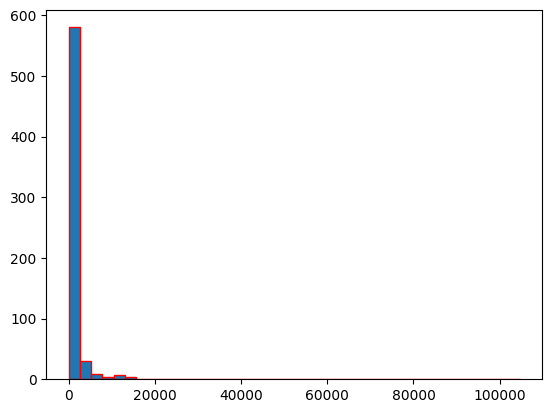

In [32]:
import matplotlib.pyplot as plt 
  
plt.hist(counts, edgecolor="red", bins=40) 
plt.show() 

In [11]:
all_labels = set()

for label in ds['label']:
    all_labels.add(label)s

In [12]:
len(all_labels)

555

In [22]:
for label in ds['label']:
    try:
        k, v = labels_counter_dict.get(relations_list[label])
        count = v + 1
        labels_counter_dict.get({k: count})
    except TypeError:
        print(label)

132
157
63
425
554
333
333
333
431
431
63
280
393
452
452
299
299
170
464
630
630
49
274
633
633
633
633
63
297
297
52
84
401
299
634
84
401
49
302
633
28
633
633
260
145
145
544
145
310
406
544
145
145
145
457
310
544
388
49
633
63
280
487
393
333
333
279
279
279
279
279
279
279
279
279
279
279
279
279
279
84
249
401
633
633
132
56
56
56
56
56
63
63
84
302
84
302
633
249
633
1
477
84
633
249
118
436
579
418
450
245
165
165
167
477
633
132
633
564
564
300
300
549
325
414
291
322
322
322
49
299
593
132
564
634
295
368
396
396
396
396
63
633
44
45
53
44
45
53
44
45
268
53
53
53
53
342
405
368
297
63
63
158
1
297
633
633
633
245
268
53
297
297
633
396
104
28
325
325
325
316
399
297
297
633
84
633
132
633
425
554
245
245
132
132
132
633
132
132
132
132
132
63
393
431
396
396
396
368
63
396
396
381
143
143
304
633
633
188
368
424
297
63
297
158
158
348
349
564
132
132
633
377
132
132
536
536
633
633
633
633
355
355
56
633
63
63
633
53
44
45
484
196
280
279
279
333
333
333
399
63
63
28
554
1

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
from datasets import DatasetDictconcatenate_datasets
ds = concatenate_datasets([ds_400k, ds_800k])

ds_train_devtest = ds.train_test_split(test_size=0.4, seed=42)
ds_devtest = ds_train_devtest['test'].train_test_split(test_size=0.5, seed=42)

all_ds = DatasetDict({
    'train': ds_train_devtest['train'],
    'val': ds_devtest['train'],
    'test': ds_devtest['test']
})

In [7]:
relations_list = pickle.load(open('relationsList.p', 'rb'))

In [7]:
modified_abstracts = {'text': [], 'label': []}

count = 0

for example in ds:
  if example['label'] == relations_list.index('none') and count <= 10000:
    modified_abstracts['text'].append(example['text'])
    modified_abstracts['label'].append(example['label'])
    count += 1
  elif example['label'] != relations_list.index('none'):
    modified_abstracts['text'].append(example['text'])
    modified_abstracts['label'].append(example['label'])
  elif example['label'] == relations_list.index('none') and count > 10000:
    continue

In [8]:
ds = Dataset.from_dict(modified_abstracts)

In [36]:
test_ds = ds

In [37]:
test_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 274791
})

In [13]:
all_ds = ds.train_test_split(test_size=0.2)

In [6]:
from datasets import DatasetDict

ds_train_devtest = ds.train_test_split(test_size=0.4, seed=42)
ds_devtest = ds_train_devtest['test'].train_test_split(test_size=0.5, seed=42)

all_ds = DatasetDict({
    'train': ds_train_devtest['train'],
    'val': ds_devtest['train'],
    'test': ds_devtest['test']
})

In [7]:
all_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 493996
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 164666
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 164666
    })
})

## Preprocess

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

custom_tokens = ["[E]", "[/E]"]

tokenizer.add_tokens(custom_tokens, special_tokens=True)

2

In [9]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [10]:
tokenized_all = all_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/493996 [00:00<?, ? examples/s]

Map:   0%|          | 0/164666 [00:00<?, ? examples/s]

Map:   0%|          | 0/164666 [00:00<?, ? examples/s]

In [11]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Evaluate

In [12]:
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
f1 = evaluate.load("f1")
recall = evaluate.load("recall")

In [13]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    results = {}
    results.update(accuracy.compute(predictions=predictions, references = labels))
    results.update(precision.compute(predictions=predictions, references = labels, average="macro"))
    results.update(f1.compute(predictions=predictions, references = labels, average="macro"))
    results.update(recall.compute(predictions=predictions, references = labels, average="macro"))

    return results

## Train

In [17]:
relations_list = pickle.load(open('relationsList.p', 'rb'))
relations_list.remove('none')

In [18]:
# Create id2label and label2id dictionaries
id2label = {i: relation for i, relation in enumerate(relations_list)}
label2id = {relation: i for i, relation in enumerate(relations_list)}

In [19]:
l = [x for x in range(639)]

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id
)

model.resize_token_embeddings(len(tokenizer))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(30524, 768)

In [34]:
pickle.dump(tokenized_all, open('data/datasets/tokenizedAll400k.p', 'wb'))

In [13]:
tokenized_all = pickle.load(open('data/datasets/tokenizedAll100k.p', 'rb'))

In [25]:
from transformers import TrainerCallback

class ThresholdCallback(TrainerCallback):
    def __init__(self, threshold):
        self.threshold = threshold

    def on_post_evaluate(self, args, state, control, model, tokenizer, metrics, **kwargs):
        # Modify the predictions by applying the threshold
        predictions = state.predictions
        modified_predictions = (predictions > self.threshold).astype(int)

        # Update the state with modified predictions
        state.predictions = modified_predictions

In [18]:
training_args = TrainingArguments(
    output_dir="models/all18",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_all["train"],
    eval_dataset=tokenized_all["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
#trainer.train()
trainer.train(resume_from_checkpoint=True)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/bwhpc/common/jupyter/te

TrainOutput(global_step=19300, training_loss=0.14737656114014938, metrics={'train_runtime': 8562.6522, 'train_samples_per_second': 288.46, 'train_steps_per_second': 2.254, 'total_flos': 6.53589806895551e+17, 'train_loss': 0.14737656114014938, 'epoch': 5.0})

## Inference

### Creating predictions

In [7]:
from transformers import pipeline
classifier = pipeline("text-classification", model="models/all18/checkpoint-19300", truncation=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
test_texts = all_ds['test']['text']
batch_size = 2000
text_batches = [test_texts[i:i + batch_size] for i in range(0, len(test_texts), batch_size)]

In [10]:
predictions = pickle.load(open('predictions_test.p', 'rb'))

In [ ]:
for batch in tqdm.tqdm(text_batches[len(predictions):]):
    predictions.append(classifier(batch))
    pickle.dump(predictions, open('predictions_test.p', 'wb'))

 15%|█▌        | 3/20 [27:52<2:37:29, 555.87s/it]

In [20]:
texts = all_ds['val']['text']
labels = [id2label[x] for x in all_ds['val']['label']]

In [45]:
predictions = pickle.load(open('predictions.p', 'rb'))
batch_size = 2000
text_batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]

In [12]:
predictions = pickle.load(open('predictions_val_for_thresholds.p', 'rb'))

In [13]:
all_predictions = [item for sublist in predictions for item in sublist]

In [14]:
len(all_predictions)

164666

In [21]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, precision_score

best_precision_single = 0
best_threshold_single = 0

for threshold in tqdm.tqdm(range(1, 100)):
    threshold /= 100

    y_true = []
    y_pred = []
    
    for index, prediction in enumerate(all_predictions):
        if prediction['score'] > threshold:
            y_true.append(labels[index])
            y_pred.append(prediction['label'])
        else:
            continue
            
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)

    # Track the best precision and threshold
    if precision >= best_precision_single and precision <= 0.95:
      best_precision_single = precision
      best_threshold_single = threshold


print(best_precision_single, best_threshold_single)

100%|██████████| 99/99 [02:16<00:00,  1.38s/it]

0.6328241525096212 0.88


In [23]:
all_labels = set()

for prediction in tqdm.tqdm(all_predictions):
    all_labels.add(prediction['label'])

100%|██████████| 164666/164666 [00:00<00:00, 2937712.99it/s]


In [24]:
from sklearn.metrics import precision_score
import tqdm

best_thresholds_dict = {}

for label in tqdm.tqdm(all_labels):
    best_precision = 0
    best_threshold = 0

    for threshold in range(1, 100):
        threshold /= 100

        y_true = []
        y_pred = []

        for index, prediction in enumerate(all_predictions):
            if label == prediction['label'] and prediction['score'] > threshold:
                y_true.append(labels[index])
                y_pred.append(label)
            else:
                continue

        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)

        # Track the best precision and threshold
        if precision >= best_precision and precision <= 0.95:
            best_precision = precision
            best_threshold = threshold
            
    #print(label, best_precision, best_threshold)
    best_thresholds_dict[label] = best_threshold

100%|██████████| 337/337 [12:38<00:00,  2.25s/it]


In [25]:
pickle.dump(best_thresholds_dict, open('best_thresholds_dict_2.p', 'wb'))

### Predictions with thresholds from dictionary separate test dataset

In [30]:
# prepare predictions and labels for testing

from datasets import DatasetDict, concatenate_datasets
best_thresholds_dict = pickle.load(open('best_thresholds_dict_2.p', 'rb'))
predictions = pickle.load(open('predictions_test.p', 'rb'))
all_predictions = [item for sublist in predictions for item in sublist]
ds_400k = pickle.load(open('data/datasets/all400k_ds.p', 'rb'))
ds_800k = pickle.load(open('data/datasets/all800k_ds.p', 'rb'))
ds = concatenate_datasets([ds_400k, ds_800k])
ds_train_devtest = ds.train_test_split(test_size=0.4, seed=42)
ds_devtest = ds_train_devtest['test'].train_test_split(test_size=0.5, seed=42)
all_ds = DatasetDict({
    'train': ds_train_devtest['train'],
    'val': ds_devtest['train'],
    'test': ds_devtest['test']
})
labels = [id2label[x] for x in all_ds['test']['label']]

In [31]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, precision_score

y_true = []
y_pred = []
count = 0

for index, prediction in enumerate(all_predictions):
    if prediction['label'] in best_thresholds_dict and prediction['score'] > best_thresholds_dict.get(prediction['label']):
        y_true.append(labels[index])
        y_pred.append(prediction['label'])
    else:
        continue

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
cf_report = classification_report(y_true, y_pred)

print(cf_report)

/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

                                                          precision    recall  f1-score   support

          http://dbpedia.org/ontology/academicDiscipline       0.96      0.97      0.97        75
  http://dbpedia.org/ontology/administrativeCollectivity       0.00      0.00      0.00         1
                 http://dbpedia.org/ontology/affiliation       0.99      0.98      0.99       186
              http://dbpedia.org/ontology/aircraftBomber       0.00      0.00      0.00         2
             http://dbpedia.org/ontology/aircraftFighter       0.71      1.00      0.83         5
                       http://dbpedia.org/ontology/album       0.99      1.00      1.00       742
                    http://dbpedia.org/ontology/alliance       1.00      1.00      1.00         7
                   http://dbpedia.org/ontology/almaMater       0.94      1.00      0.97        48
                 http://dbpedia.org/ontology/archipelago       0.98      0.91      0.94        55
                   

/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Predictions with thresholds from dictionary same testset

In [ ]:
# prepare predictions and labels for testing

from datasets import DatasetDict, concatenate_datasets
predictions = pickle.load(open('predictions.p', 'rb'))
all_predictions = [item for sublist in predictions for item in sublist]
ds = concatenate_datasets([ds_400k, ds_800k])
ds_train_devtest = ds.train_test_split(test_size=0.4, seed=42)
ds_devtest = ds_train_devtest['test'].train_test_split(test_size=0.5, seed=42)
all_ds = DatasetDict({
    'train': ds_train_devtest['train'],
    'val': ds_devtest['train'],
    'test': ds_devtest['test']
})
labels = [id2label[x] for x in all_ds['label']]

In [102]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, precision_score

y_true = []
y_pred = []
count = 0

for index, prediction in enumerate(all_predictions):
    if prediction['score'] > best_thresholds_dict.get(prediction['label']):
        y_true.append(labels[index])
        y_pred.append(prediction['label'])
    elif prediction['score'] >= 0.89 and prediction['score'] < best_thresholds_dict.get(prediction['label']):
        count += 1
    else:
        continue

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
cf_report = classification_report(y_true, y_pred)

print(cf_report)

/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

                                                          precision    recall  f1-score   support

             http://dbpedia.org/ontology/academicAdvisor       0.00      0.00      0.00         1
          http://dbpedia.org/ontology/academicDiscipline       0.96      0.96      0.96       115
        http://dbpedia.org/ontology/administrativeCenter       0.00      0.00      0.00         2
  http://dbpedia.org/ontology/administrativeCollectivity       0.00      0.00      0.00         2
                 http://dbpedia.org/ontology/affiliation       0.99      0.98      0.99       138
              http://dbpedia.org/ontology/aircraftBomber       0.00      0.00      0.00         2
             http://dbpedia.org/ontology/aircraftFighter       0.60      1.00      0.75         3
                       http://dbpedia.org/ontology/album       0.99      1.00      1.00       924
                    http://dbpedia.org/ontology/alliance       1.00      1.00      1.00        11
                   

/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Predictions with single threshold same testset

In [91]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, precision_score

y_true = []
y_pred = []

for index, prediction in enumerate(all_predictions):
    if prediction['score'] > best_threshold_single:
        y_true.append(labels[index])
        y_pred.append(prediction['label'])
    else:
        continue

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
cf_report = classification_report(y_true, y_pred)

print(cf_report)

/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

                                                         precision    recall  f1-score   support

         http://dbpedia.org/ontology/academicDiscipline       0.85      0.88      0.87       268
 http://dbpedia.org/ontology/administrativeCollectivity       0.00      0.00      0.00         2
                http://dbpedia.org/ontology/affiliation       0.95      0.99      0.97       287
                      http://dbpedia.org/ontology/album       0.99      1.00      0.99      1020
                  http://dbpedia.org/ontology/almaMater       0.91      1.00      0.95       259
                http://dbpedia.org/ontology/archipelago       0.92      0.94      0.93        96
                  http://dbpedia.org/ontology/architect       0.98      0.99      0.99       174
         http://dbpedia.org/ontology/architecturalStyle       0.96      0.97      0.97        74
             http://dbpedia.org/ontology/arrondissement       0.00      0.00      0.00         2
                     http://d

/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Building classification report

In [62]:
import pandas as pd

report = classification_report(y_true, y_pred, output_dict=True)
dataframe = pd.DataFrame.from_dict(report)
dataframe.to_csv('classification_report_4.csv', index = True)

/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

## Testing

In [36]:
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
f1 = evaluate.load("f1")
recall = evaluate.load("recall")

In [27]:
# Load the model from the directory
model = AutoModelForSequenceClassification.from_pretrained("models/all17/checkpoint-19300")
tokenizer = AutoTokenizer.from_pretrained("models/all17/checkpoint-19300")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [28]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

def compute_metrics_eval(p):
    predictions, labels = p.predictions, p.label_ids
    preds = (predictions > 0.4).astype(int)

    # Flatten multilabel indicators to 1D arrays
    labels = labels.flatten()
    preds = preds.flatten()

    # Compute accuracy
    accuracy = accuracy_score(labels, preds, labels=l)

    # Compute precision, recall, and f1
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [29]:
relations_list = pickle.load(open('relationsList.p', 'rb'))
relations_list.remove('none')

In [30]:
l = [x for x in range(639)]

In [34]:
from sklearn.metrics import classification_report
import pandas as pd

def compute_metrics_eval(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    print(classification_report(labels, predictions, labels=l, target_names=relations_list))
    report = classification_report(labels, predictions, labels=l, target_names=relations_list, output_dict=True)
    dataframe = pd.DataFrame.from_dict(report)
    dataframe.to_csv('classification_report.csv', index = True)

    results = {}
    results.update(accuracy.compute(predictions=predictions, references = labels))
    results.update(precision.compute(predictions=predictions, references = labels, average="macro"))
    results.update(f1.compute(predictions=predictions, references = labels, average="macro"))
    results.update(recall.compute(predictions=predictions, references = labels, average="macro"))

    return results

In [35]:
# Set up the Trainer for evaluation
eval_args = TrainingArguments(
    output_dir="models/all17_eval",
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
)
eval_trainer = Trainer(
    model=model,
    args=eval_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_eval,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [36]:
# Evaluate on the test set with a different threshold
test_results = eval_trainer.evaluate(tokenized_all["test"])

/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

                                                               precision    recall  f1-score   support

                  http://dbpedia.org/ontology/academicAdvisor       0.00      0.00      0.00         6
               http://dbpedia.org/ontology/academicDiscipline       0.70      0.79      0.74       440
                         http://dbpedia.org/ontology/actScore       0.00      0.00      0.00         0
                    http://dbpedia.org/ontology/addressInRoad       0.00      0.00      0.00         0
             http://dbpedia.org/ontology/administrativeCenter       0.00      0.00      0.00        11
       http://dbpedia.org/ontology/administrativeCollectivity       0.00      0.00      0.00         6
           http://dbpedia.org/ontology/administrativeDistrict       0.00      0.00      0.00         7
                    http://dbpedia.org/ontology/administrator       0.00      0.00      0.00         0
                      http://dbpedia.org/ontology/affiliation       0.87

/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average